In [1]:
#Code adapted from https://github.com/nchlis/keras_UNET_segmentation
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
#import h5py
from keras.preprocessing import image# for RGB images
from keras.preprocessing.image import load_img

import os
#import imageio
from sklearn.model_selection import train_test_split
import cv2# cv2.imread() for grayscale images

import matplotlib.pyplot as plt
from mpl_toolkits import axes_grid1
from keras.models import Model
from keras.layers import Input
from keras.layers import Activation
from keras.layers import BatchNormalization
from keras.layers import Dense
#from keras.layers import Flatten
from keras.layers import AveragePooling2D
from keras.layers.convolutional import Conv2D, MaxPooling2D, UpSampling2D, AveragePooling2D, Conv2DTranspose
from keras.layers.merge import concatenate #Concatenate (capital C) not working 
#from keras.utils.vis_utils import plot_model
from keras.layers import Dropout
from tensorflow.keras.layers import SeparableConv2D
from tensorflow.keras.layers import DepthwiseConv2D

from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from keras.callbacks import CSVLogger
import time
import skimage.transform

In [2]:
def add_colorbar(im, aspect=20, pad_fraction=0.5, **kwargs):
    """
    Add a vertical color bar to an image plot.
    https://stackoverflow.com/questions/18195758/set-matplotlib-colorbar-size-to-match-graph
    """
    divider = axes_grid1.make_axes_locatable(im.axes)
    width = axes_grid1.axes_size.AxesY(im.axes, aspect=1./aspect)
    pad = axes_grid1.axes_size.Fraction(pad_fraction, width)
    current_ax = plt.gca()
    cax = divider.append_axes("right", size=width, pad=pad)
    plt.sca(current_ax)
    return im.axes.figure.colorbar(im, cax=cax, **kwargs)

def rotateT(X,angle):
    #rotate image tensor, TF order, single channel
    X_rot = np.zeros_like(X)
    #repeat for every channel
    for ch in np.arange(X.shape[-1]):
        #print('channel',ch)
        #repeat for every image
        for i in np.arange(X.shape[0]):
            #print('image',i)
            X_rot[i,:,:,ch] = skimage.transform.rotate(X[i,:,:,ch],angle=angle,resize=False,preserve_range=True,mode='edge')
    return(X_rot)

def shiftT(X,dx,dy):
    #rotate image tensor, TF order, single channel
    X_shift = np.zeros_like(X)
    #repeat for every image
    tform = skimage.transform.SimilarityTransform(translation=(dx, dy))
    for i in np.arange(X.shape[0]):
        #print('image',i)
        X_shift[i,:,:,:] = skimage.transform.warp(X[i,:,:,:],tform,mode='edge')
    return(X_shift)

#%%
def aug_generator(X_raw=None,Y_raw=None,
                  batch_size=4,
                  flip_axes=['x','y'],
                  rotation_angles=[5,15]):
                  #noise_gaussian_mean=0,
                  #noise_gaussian_var=1e-2):
                  #noise_snp_amount=0.05):
    
    batch_size=batch_size#recommended batch size    
    Ndatapoints = len(X_raw)
    #Naugmentations=4 #original + flip, rotation, noise_gaussian, noise_snp
    
    while(True):
        #print('start!')
        ix_randomized = np.random.choice(Ndatapoints,size=Ndatapoints,replace=False)
        ix_batches = np.array_split(ix_randomized,int(Ndatapoints/batch_size))
        for b in range(len(ix_batches)):
            #print('step',b,'of',len(ix_batches))
            ix_batch = ix_batches[b]
            current_batch_size=len(ix_batch)
            #print('size of current batch',current_batch_size)
            #print(ix_batch)
            X_batch = X_raw[ix_batch,:,:,:].copy()#.copy() to leave original unchanged
            Y_batch = Y_raw[ix_batch,:,:,:].copy()#.copy() to leave original unchanged
            
            #now do augmentation on images and masks
            #iterate over each image in the batch
            for img in range(current_batch_size):
                #print('current_image',img,': ',ix_batch[img])
                do_aug=np.random.choice([True, False],size=1)[0]#50-50 chance
                if do_aug == True:
                    #print('flipping',img)
                    flip_axis_selected = np.random.choice(flip_axes,1,replace=False)[0]
                    if flip_axis_selected == 'x':
                        flip_axis_selected = 1
                    else: # 'y'
                        flip_axis_selected = 0
                    #flip an axis
                    X_batch[img,:,:,:] = np.flip(X_batch[img,:,:,:],axis=flip_axis_selected)
                    Y_batch[img,:,:,:] = np.flip(Y_batch[img,:,:,:],axis=flip_axis_selected)
                    #print('Flip on axis',flip_axis_selected)
                
                do_aug=np.random.choice([True, False],size=1)[0]#50-50 chance
                if do_aug == True:
                    #print('rotating',img)
                    rotation_angle_selected = np.random.uniform(low=rotation_angles[0],high=rotation_angles[1],size=1)[0]
                    #rotate the image
                    X_batch[img,:,:,:] = rotateT(np.expand_dims(X_batch[img,:,:,:],axis=0),angle=rotation_angle_selected)
                    Y_batch[img,:,:,:] = rotateT(np.expand_dims(Y_batch[img,:,:,:],axis=0),angle=rotation_angle_selected)
                    #print('Rotate angle',rotation_angle_selected)
            yield(X_batch,Y_batch)
            #print('step end after',b,'of',len(ix_batches))


In [3]:
gpu_available = tf.test.is_gpu_available()
is_cuda_gpu_available = tf.test.is_gpu_available(cuda_only=True)
is_cuda_gpu_min_3 = tf.test.is_gpu_available(True, (3,0))

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


2023-01-17 11:28:55.486311: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-17 11:28:58.097034: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /device:GPU:0 with 11240 MB memory:  -> device: 0, name: Tesla P100-PCIE-12GB, pci bus id: 0000:03:00.0, compute capability: 6.0
2023-01-17 11:28:58.102316: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /device:GPU:1 with 11296 MB memory:  -> device: 1, name: Tesla P100-PCIE-12GB, pci bus id: 0000:04:00.0, compute capability: 6.0
2023-01-17 11:28:58.110368: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /device:GPU:0 with 11240 MB memory:  -> device: 0, name: Tesla P100-PCIE-12GB, pci bus id: 0000:03:0

In [4]:
!pwd

/sfs/qumulo/qhome/yl4dt/DS7406 Files/Team_3


(512, 512, 3)
0.3843137254901961
(512, 512, 3)
[0. 1.]


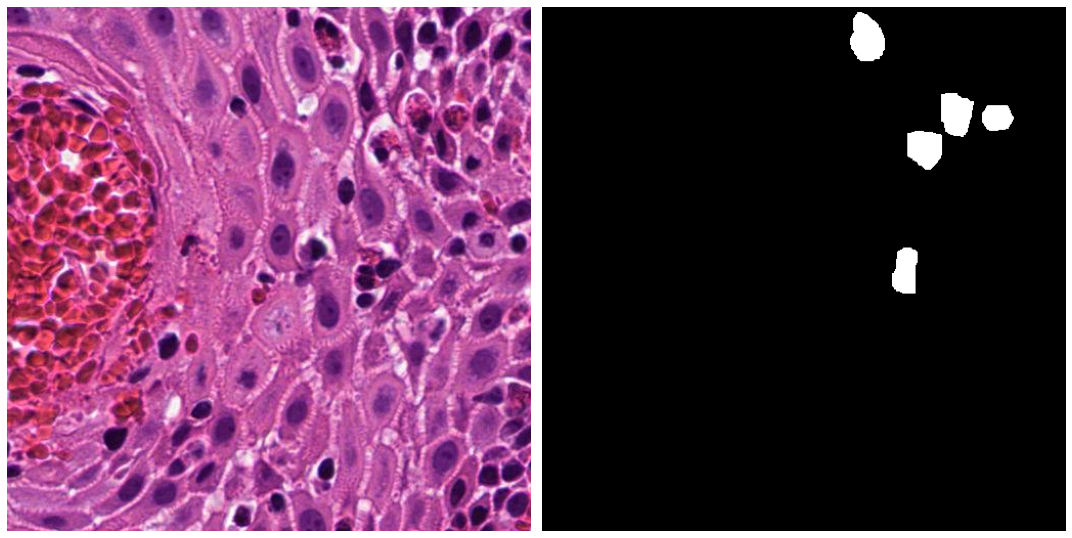

In [5]:
#Simple test to see image parameters
data_path = "/sfs/qumulo/qhome/yl4dt/DS7406 Files/Team_3/EoE_data/Full_Model/"
imgs = np.array(load_img(data_path + '/Images/all_imgs/E-02_1_15361_17921.jpg'))/255.
lbl = np.array(load_img(data_path + 'Masks/E-02_1_15361_17921.png'))/255.
print(imgs.shape)
print(imgs[0,0,0])
print(lbl.shape)
print(np.unique(lbl))
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 15))

ax[0].imshow(imgs)
ax[0].axis('off')
ax[-1].imshow(lbl)
ax[-1].axis('off')
plt.tight_layout()            
plt.show()

In [6]:
#%% load the images
img_folder = data_path + 'Images/all_imgs'
msk_folder = data_path + 'Masks'
target_height = 512
target_width = 512
Nimages = 514#514 images, each image has 3 channels

# load the filenames of all images
img_filenames = np.array(sorted(os.listdir(img_folder)))#sort to alphabetical order
wells = [f.split('.')[0] for f in img_filenames][1:]
#wells = [w.split('-')[1] for w in wells]
#wells = [w.split('_')[0] for w in wells]
#wells = np.sort(np.unique(wells))
#print(len(wells))
#assert len(img_filenames)==Nimages*3#2 channels

In [7]:
#wells = [f.split('_')[0] for f in img_filenames]
#print(wells)
#wells = np.sort(np.unique(wells))#e.g. A01, A02, ..., E04
#print(wells)
channels = [1,2,3]

#%%load the images
#images, 2 channels
X = np.zeros(shape=(Nimages,target_height,target_width,3),dtype='float32')
Y = np.zeros(shape=(Nimages,target_height,target_width,1),dtype='float32')

In [8]:
data_load_start = time.process_time()
i=0
for w in  wells:
    #print('loading image ',i+1)
    #cv2 is better for grayscale images, use 
    #load the image & resize & normalize
    img = np.array(load_img(img_folder+'/'+w +'.jpg', target_size=(target_height,target_width,3)))/255.
    X[i,:,:,:]=img
    #print('loading mask')
    lbl = np.array(load_img(msk_folder+'/'+w +'.png', target_size=(target_height,target_width,3),grayscale = True))/255.
    #create binary image from [0,1] to {0,1}, using 0.5 as threshold
    lbl[lbl<0.5]=0
    lbl[lbl>=0.5]=1
    #print(lbl.shape)
    Y[i,:,:,0]=lbl
    i=i+1
    #print()#add a blank line for readability
data_load_time = time.process_time()-data_load_start
print(data_load_time)
#double-check that the masks are binary
#assert np.array_equal(np.unique(Y), [0,1])

/usr/local/lib/python3.9/site-packages/keras_preprocessing/image/utils.py:107: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '


3.7818320290000003


In [9]:
print(lbl.shape)
print(np.unique(lbl))
print(X.shape)
print(np.unique(Y))

(512, 512)
[0. 1.]
(514, 512, 512, 3)
[0. 1.]


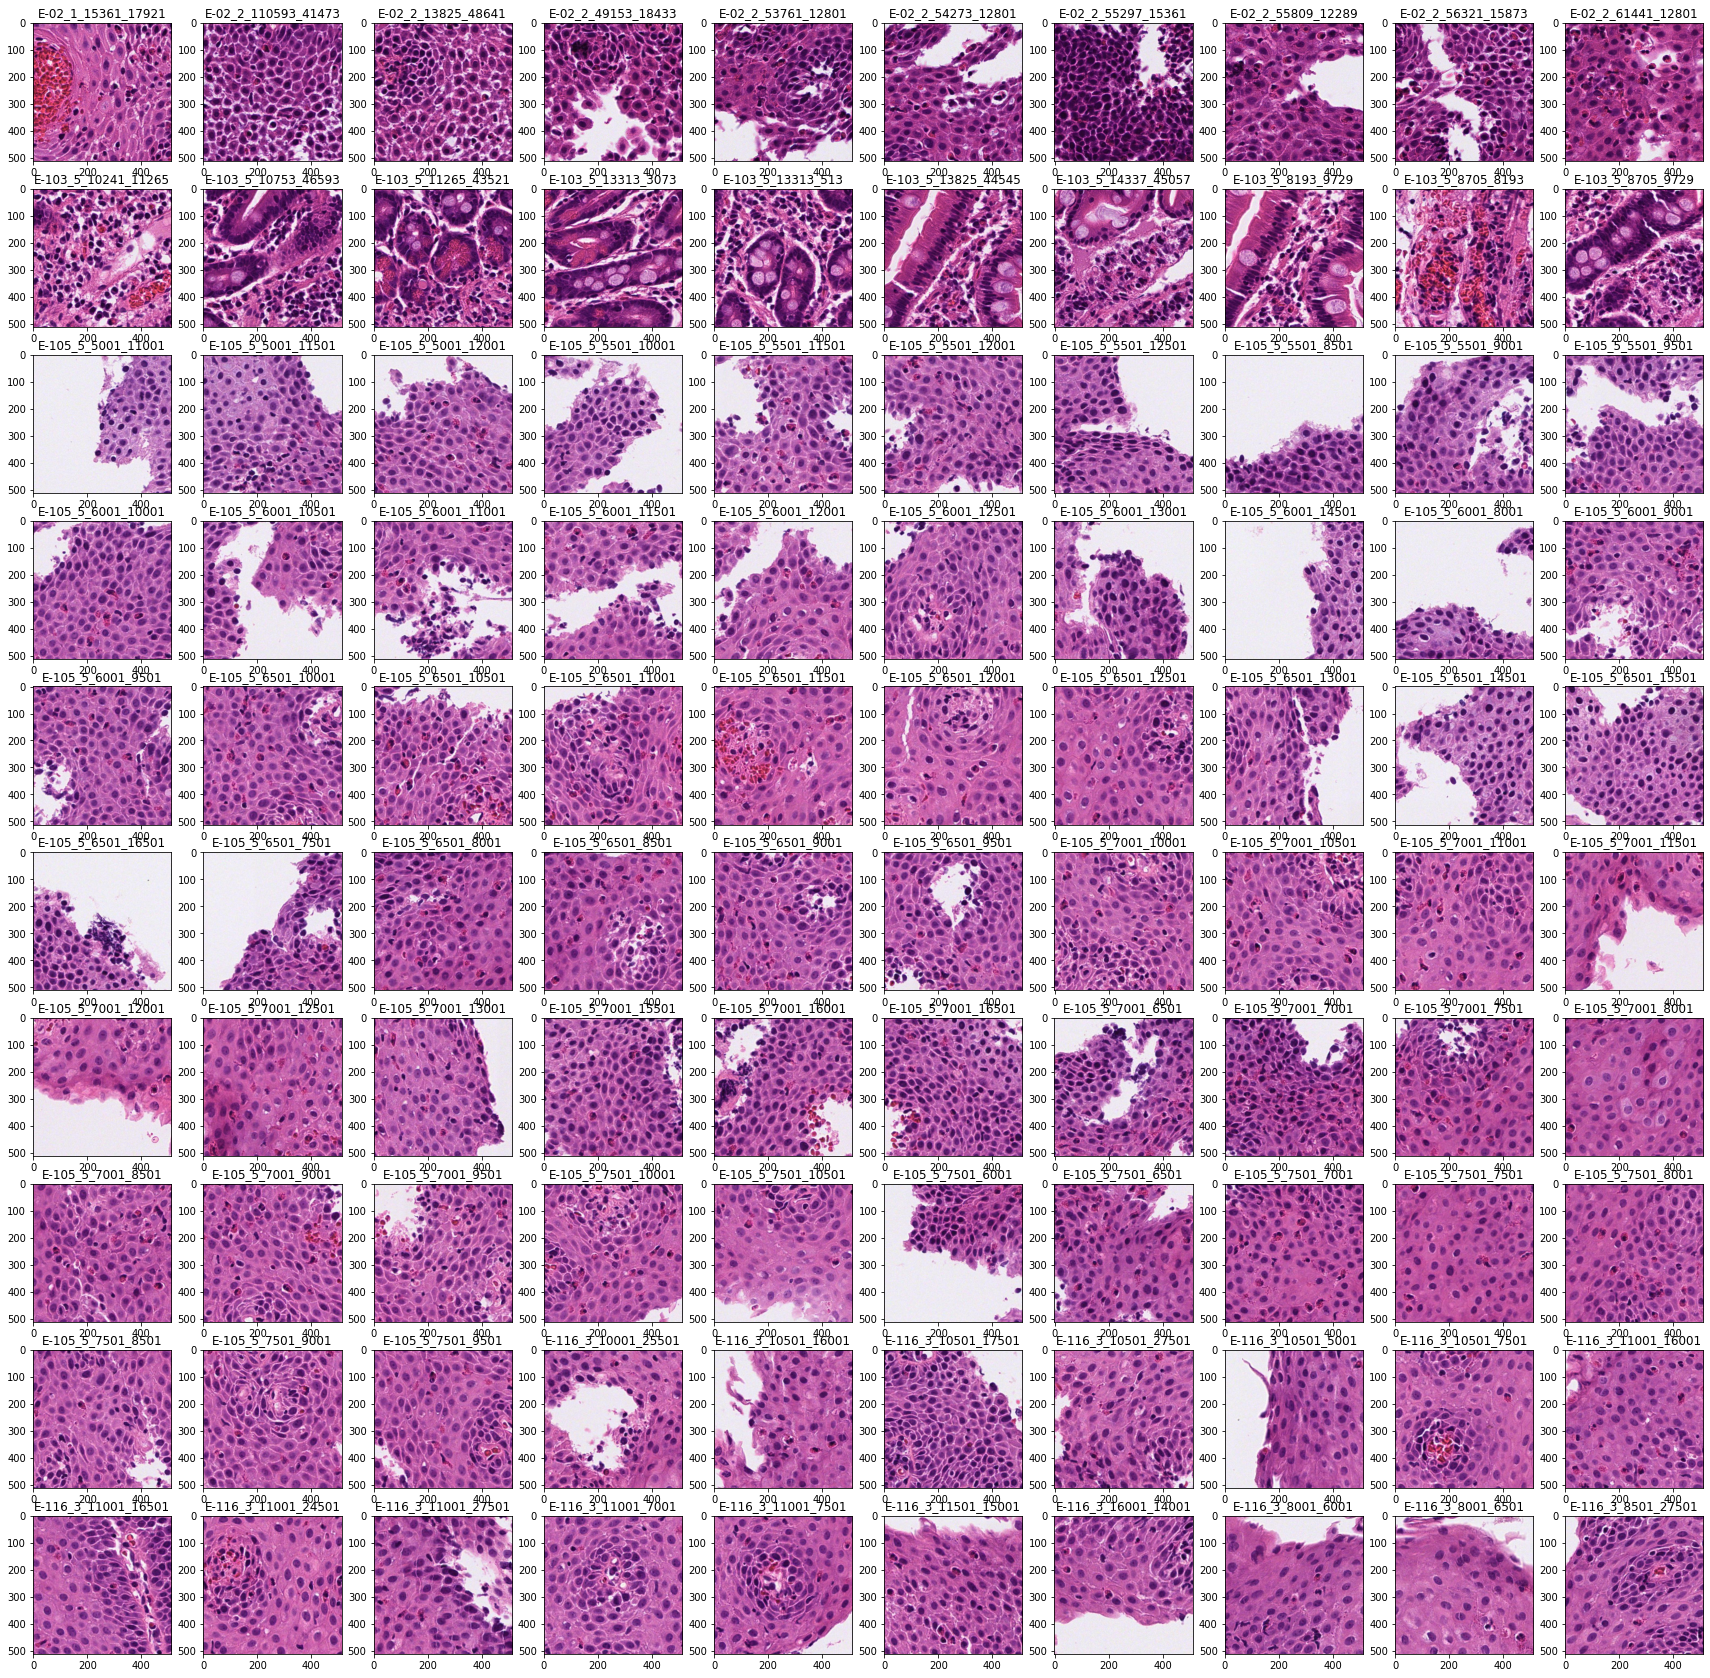

In [10]:
#Plot first few images to ensure they are read properly
#plot channel 0
img=0    
fig, axes = plt.subplots(10,10, figsize = (30,30))
for i in range(10):
    for j in range(10):
        axes[i,j].imshow(X[img,:,:,:])
        axes[i,j].set_title(wells[img])
        img=img+1

# START

In [11]:
save_path = "/sfs/qumulo/qhome/yl4dt/DS7406 Files/Team_3/EoE_data/Full_Model/finalResults/depthwiseModel/"
ix = np.arange(len(wells))

ix_tr, ix_val_ts = train_test_split(ix,train_size=60, random_state=0)
ix_val, ix_ts = train_test_split(ix_val_ts,train_size=20, random_state=0)

#sanity check, no overlap between train, validation and test sets
assert len(np.intersect1d(ix_tr,ix_val))==0
assert len(np.intersect1d(ix_tr,ix_ts))==0
assert len(np.intersect1d(ix_val,ix_ts))==0

X_tr = X[ix_tr,:]
Y_tr = Y[ix_tr,:]

X_val = X[ix_val,:]
Y_val = Y[ix_val,:]

X_ts = X[ix_ts,:]
Y_ts = Y[ix_ts,:]
np.save(save_path + 'Data/X_ts.npy',X_ts)

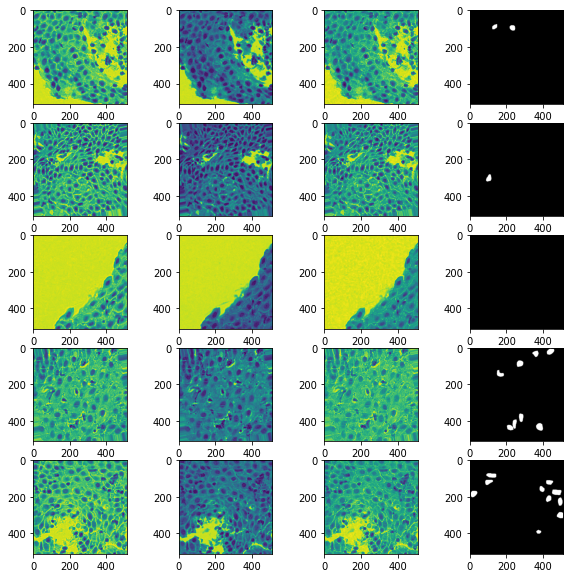

In [12]:
gen_train = aug_generator(X_tr,Y_tr,batch_size=5,flip_axes=['x','y'])


#plot the augmentations
X_batch, Y_batch = next(gen_train)
Nbatch=len(X_batch)

#%
fig, axes = plt.subplots(Nbatch,4, figsize=(10,10))
for i in range(Nbatch):
    #print(i)
    axes[i,0].imshow(X_batch[i,:,:,0])
    axes[i,1].imshow(X_batch[i,:,:,1])
    axes[i,2].imshow(X_batch[i,:,:,2])
    axes[i,3].imshow(Y_batch[i,:,:,0],cmap='gray')
    
#%% set-up the UNET model

#model parameters
bnorm_axis = -1
#filter sizes of the original model
n_filters = np.array([64, 128, 256, 512, 1024])
drop_rate=0.5
#drop_train=True
drop_train=False
#downsize the UNET for this example.
#the smaller network is faster to train
#and produces excellent results on the dataset at hand
n_filters = (n_filters/8).astype('int')

#input
input_tensor = Input(shape=X_tr.shape[1:], name='input_tensor')

In [13]:
def createModel(input_tensor, bnorm_axis, n_filters, drop_rate, drop_train):
    ####################################
    # encoder (contracting path)
    ####################################
    #encoder block 0
    nfilters = n_filters
    e0 = Conv2D(filters=nfilters[0], kernel_size=(3,3), padding='same')(input_tensor)
    e0 = BatchNormalization(axis=bnorm_axis)(e0)
    e0 = Activation('relu')(e0)
    e0 = Conv2D(filters=nfilters[0], kernel_size=(3,3), padding='same')(e0)
    e0 = BatchNormalization(axis=bnorm_axis)(e0)
    e0 = Activation('relu')(e0)

    #encoder block 1
    e1 = MaxPooling2D((2, 2))(e0)
    e1 = Conv2D(filters=nfilters[1], kernel_size=(3,3), padding='same')(e1)
    e1 = BatchNormalization(axis=bnorm_axis)(e1)
    e1 = Activation('relu')(e1)
    e1 = Conv2D(filters=nfilters[1], kernel_size=(3,3), padding='same')(e1)
    e1 = BatchNormalization(axis=bnorm_axis)(e1)
    e1 = Activation('relu')(e1)

    #encoder block 2
    e2 = Dropout(drop_rate)(e1, training = drop_train)
    e2 = MaxPooling2D((2, 2))(e2)
    e2 = Conv2D(filters=nfilters[2], kernel_size=(3,3), padding='same')(e2)
    e2 = BatchNormalization(axis=bnorm_axis)(e2)
    e2 = Activation('relu')(e2)
    e2 = Conv2D(filters=nfilters[2], kernel_size=(3,3), padding='same')(e2)
    e2 = BatchNormalization(axis=bnorm_axis)(e2)
    e2 = Activation('relu')(e2)

    #encoder block 3
    e3 = Dropout(drop_rate)(e2, training = drop_train)
    e3 = MaxPooling2D((2, 2))(e3)
    e3 = Conv2D(filters=nfilters[3], kernel_size=(3,3), padding='same')(e3)
    e3 = BatchNormalization(axis=bnorm_axis)(e3)
    e3 = Activation('relu')(e3)
    e3 = Conv2D(filters=nfilters[3], kernel_size=(3,3), padding='same')(e3)
    e3 = BatchNormalization(axis=bnorm_axis)(e3)
    e3 = Activation('relu')(e3)

    #encoder block 4
    e4 = Dropout(drop_rate)(e3, training = drop_train)
    e4 = MaxPooling2D((2, 2))(e4)
    e4 = Conv2D(filters=nfilters[4], kernel_size=(3,3), padding='same')(e4)
    e4 = BatchNormalization(axis=bnorm_axis)(e4)
    e4 = Activation('relu')(e4)
    e4 = Conv2D(filters=nfilters[4], kernel_size=(3,3), padding='same')(e4)
    e4 = BatchNormalization(axis=bnorm_axis)(e4)
    e4 = Activation('relu')(e4)
    #e4 = MaxPooling2D((2, 2))(e4)

    ####################################
    # decoder (expansive path)
    ####################################

    #decoder block 3
    d3 = Dropout(drop_rate)(e4, training = drop_train)
    d3=UpSampling2D((2, 2),)(d3)
    d3=concatenate([e3,d3], axis=-1)#skip connection
    d3=Conv2DTranspose(nfilters[3], (3, 3), padding='same')(d3)
    d3=BatchNormalization(axis=bnorm_axis)(d3)
    d3=Activation('relu')(d3)
    d3=Conv2DTranspose(nfilters[3], (3, 3), padding='same')(d3)
    d3=BatchNormalization(axis=bnorm_axis)(d3)
    d3=Activation('relu')(d3)

    #decoder block 2
    d2 = Dropout(drop_rate)(d3, training = drop_train)
    d2=UpSampling2D((2, 2),)(d2)
    d2=concatenate([e2,d2], axis=-1)#skip connection
    d2=Conv2DTranspose(nfilters[2], (3, 3), padding='same')(d2)
    d2=BatchNormalization(axis=bnorm_axis)(d2)
    d2=Activation('relu')(d2)
    d2=Conv2DTranspose(nfilters[2], (3, 3), padding='same')(d2)
    d2=BatchNormalization(axis=bnorm_axis)(d2)
    d2=Activation('relu')(d2)

    #decoder block 1
    d1=UpSampling2D((2, 2),)(d2)
    d1=concatenate([e1,d1], axis=-1)#skip connection
    d1=Conv2DTranspose(nfilters[1], (3, 3), padding='same')(d1)
    d1=BatchNormalization(axis=bnorm_axis)(d1)
    d1=Activation('relu')(d1)
    d1=Conv2DTranspose(nfilters[1], (3, 3), padding='same')(d1)
    d1=BatchNormalization(axis=bnorm_axis)(d1)
    d1=Activation('relu')(d1)

    #decoder block 0
    d0=UpSampling2D((2, 2),)(d1)
    d0=concatenate([e0,d0], axis=-1)#skip connection
    d0=Conv2DTranspose(nfilters[0], (3, 3), padding='same')(d0)
    d0=BatchNormalization(axis=bnorm_axis)(d0)
    d0=Activation('relu')(d0)
    d0=Conv2DTranspose(nfilters[0], (3, 3), padding='same')(d0)
    d0=BatchNormalization(axis=bnorm_axis)(d0)
    d0=Activation('relu')(d0)

    #output
    #out_class = Dense(1)(d0)
    out_class = Conv2D(1, (1, 1), padding='same')(d0)
    out_class = Activation('sigmoid',name='output')(out_class)
    
    model=Model(inputs=input_tensor,outputs=out_class)
    return model

In [14]:
def createDilatedModel(input_tensor, bnorm_axis, n_filters, drop_rate, drop_train, dilation):
    ####################################
    # encoder (contracting path)
    ####################################
    #encoder block 0
    nfilters = n_filters
    e0 = Conv2D(filters=nfilters[0], kernel_size=(3,3), padding='same', dilation_rate = dilation)(input_tensor)
    e0 = BatchNormalization(axis=bnorm_axis)(e0)
    e0 = Activation('relu')(e0)
    e0 = Conv2D(filters=nfilters[0], kernel_size=(3,3), padding='same', dilation_rate = dilation)(e0)
    e0 = BatchNormalization(axis=bnorm_axis)(e0)
    e0 = Activation('relu')(e0)

    #encoder block 1
    e1 = MaxPooling2D((2, 2))(e0)
    e1 = Conv2D(filters=nfilters[1], kernel_size=(3,3), padding='same', dilation_rate = dilation)(e1)
    e1 = BatchNormalization(axis=bnorm_axis)(e1)
    e1 = Activation('relu')(e1)
    e1 = Conv2D(filters=nfilters[1], kernel_size=(3,3), padding='same', dilation_rate = dilation)(e1)
    e1 = BatchNormalization(axis=bnorm_axis)(e1)
    e1 = Activation('relu')(e1)

    #encoder block 2
    e2 = Dropout(drop_rate)(e1, training = drop_train)
    e2 = MaxPooling2D((2, 2))(e2)
    e2 = Conv2D(filters=nfilters[2], kernel_size=(3,3), padding='same', dilation_rate = dilation)(e2)
    e2 = BatchNormalization(axis=bnorm_axis)(e2)
    e2 = Activation('relu')(e2)
    e2 = Conv2D(filters=nfilters[2], kernel_size=(3,3), padding='same', dilation_rate = dilation)(e2)
    e2 = BatchNormalization(axis=bnorm_axis)(e2)
    e2 = Activation('relu')(e2)

    #encoder block 3
    e3 = Dropout(drop_rate)(e2, training = drop_train)
    e3 = MaxPooling2D((2, 2))(e3)
    e3 = Conv2D(filters=nfilters[3], kernel_size=(3,3), padding='same', dilation_rate = dilation)(e3)
    e3 = BatchNormalization(axis=bnorm_axis)(e3)
    e3 = Activation('relu')(e3)
    e3 = Conv2D(filters=nfilters[3], kernel_size=(3,3), padding='same', dilation_rate = dilation)(e3)
    e3 = BatchNormalization(axis=bnorm_axis)(e3)
    e3 = Activation('relu')(e3)

    #encoder block 4
    e4 = Dropout(drop_rate)(e3, training = drop_train)
    e4 = MaxPooling2D((2, 2))(e4)
    e4 = Conv2D(filters=nfilters[4], kernel_size=(3,3), padding='same', dilation_rate = dilation)(e4)
    e4 = BatchNormalization(axis=bnorm_axis)(e4)
    e4 = Activation('relu')(e4)
    e4 = Conv2D(filters=nfilters[4], kernel_size=(3,3), padding='same', dilation_rate = dilation)(e4)
    e4 = BatchNormalization(axis=bnorm_axis)(e4)
    e4 = Activation('relu')(e4)
    #e4 = MaxPooling2D((2, 2))(e4)

    ####################################
    # decoder (expansive path)
    ####################################

    #decoder block 3
    d3 = Dropout(drop_rate)(e4, training = drop_train)
    d3=UpSampling2D((2, 2),)(d3)
    d3=concatenate([e3,d3], axis=-1)#skip connection
    d3=Conv2DTranspose(nfilters[3], (3, 3), padding='same', dilation_rate = dilation)(d3)
    d3=BatchNormalization(axis=bnorm_axis)(d3)
    d3=Activation('relu')(d3)
    d3=Conv2DTranspose(nfilters[3], (3, 3), padding='same', dilation_rate = dilation)(d3)
    d3=BatchNormalization(axis=bnorm_axis)(d3)
    d3=Activation('relu')(d3)

    #decoder block 2
    d2 = Dropout(drop_rate)(d3, training = drop_train)
    d2=UpSampling2D((2, 2),)(d2)
    d2=concatenate([e2,d2], axis=-1)#skip connection
    d2=Conv2DTranspose(nfilters[2], (3, 3), padding='same', dilation_rate = dilation)(d2)
    d2=BatchNormalization(axis=bnorm_axis)(d2)
    d2=Activation('relu')(d2)
    d2=Conv2DTranspose(nfilters[2], (3, 3), padding='same', dilation_rate = dilation)(d2)
    d2=BatchNormalization(axis=bnorm_axis)(d2)
    d2=Activation('relu')(d2)

    #decoder block 1
    d1=UpSampling2D((2, 2),)(d2)
    d1=concatenate([e1,d1], axis=-1)#skip connection
    d1=Conv2DTranspose(nfilters[1], (3, 3), padding='same', dilation_rate = dilation)(d1)
    d1=BatchNormalization(axis=bnorm_axis)(d1)
    d1=Activation('relu')(d1)
    d1=Conv2DTranspose(nfilters[1], (3, 3), padding='same', dilation_rate = dilation)(d1)
    d1=BatchNormalization(axis=bnorm_axis)(d1)
    d1=Activation('relu')(d1)

    #decoder block 0
    d0=UpSampling2D((2, 2),)(d1)
    d0=concatenate([e0,d0], axis=-1)#skip connection
    d0=Conv2DTranspose(nfilters[0], (3, 3), padding='same', dilation_rate = dilation)(d0)
    d0=BatchNormalization(axis=bnorm_axis)(d0)
    d0=Activation('relu')(d0)
    d0=Conv2DTranspose(nfilters[0], (3, 3), padding='same', dilation_rate = dilation)(d0)
    d0=BatchNormalization(axis=bnorm_axis)(d0)
    d0=Activation('relu')(d0)

    #output
    #out_class = Dense(1)(d0)
    out_class = Conv2D(1, (1, 1), padding='same')(d0)
    out_class = Activation('sigmoid',name='output')(out_class)
    
    model=Model(inputs=input_tensor,outputs=out_class)
    return model

In [15]:
def createPyramidDilatedModel(input_tensor, bnorm_axis, n_filters, drop_rate, drop_train):
    ####################################
    # encoder (contracting path)
    ####################################
    #encoder block 0
    nfilters = n_filters
    e0 = Conv2D(filters=nfilters[0], kernel_size=(3,3), padding='same', dilation_rate = 3)(input_tensor)
    e0 = BatchNormalization(axis=bnorm_axis)(e0)
    e0 = Activation('relu')(e0)
    e0 = Conv2D(filters=nfilters[0], kernel_size=(3,3), padding='same', dilation_rate = 6)(e0)
    e0 = BatchNormalization(axis=bnorm_axis)(e0)
    e0 = Activation('relu')(e0)
    

    #encoder block 1
    e1 = MaxPooling2D((2, 2))(e0)
    e1 = Conv2D(filters=nfilters[1], kernel_size=(3,3), padding='same', dilation_rate = 3)(e1)
    e1 = BatchNormalization(axis=bnorm_axis)(e1)
    e1 = Activation('relu')(e1)
    e1 = Conv2D(filters=nfilters[1], kernel_size=(3,3), padding='same', dilation_rate = 6)(e1)
    e1 = BatchNormalization(axis=bnorm_axis)(e1)
    e1 = Activation('relu')(e1)

    #encoder block 2
    e2 = Dropout(drop_rate)(e1, training = drop_train)
    e2 = MaxPooling2D((2, 2))(e2)
    e2 = Conv2D(filters=nfilters[2], kernel_size=(3,3), padding='same', dilation_rate = 3)(e2)
    e2 = BatchNormalization(axis=bnorm_axis)(e2)
    e2 = Activation('relu')(e2)
    e2 = Conv2D(filters=nfilters[2], kernel_size=(3,3), padding='same', dilation_rate = 6)(e2)
    e2 = BatchNormalization(axis=bnorm_axis)(e2)
    e2 = Activation('relu')(e2)

    #encoder block 3
    e3 = Dropout(drop_rate)(e2, training = drop_train)
    e3 = MaxPooling2D((2, 2))(e3)
    e3 = Conv2D(filters=nfilters[3], kernel_size=(3,3), padding='same', dilation_rate = 3)(e3)
    e3 = BatchNormalization(axis=bnorm_axis)(e3)
    e3 = Activation('relu')(e3)
    e3 = Conv2D(filters=nfilters[3], kernel_size=(3,3), padding='same', dilation_rate = 6)(e3)
    e3 = BatchNormalization(axis=bnorm_axis)(e3)
    e3 = Activation('relu')(e3)

    #encoder block 4
    e4 = Dropout(drop_rate)(e3, training = drop_train)
    e4 = MaxPooling2D((2, 2))(e4)
    e4 = Conv2D(filters=nfilters[4], kernel_size=(3,3), padding='same')(e4)
    e4 = BatchNormalization(axis=bnorm_axis)(e4)
    e4 = Activation('relu')(e4)
    e4 = Conv2D(filters=nfilters[4], kernel_size=(3,3), padding='same')(e4)
    e4 = BatchNormalization(axis=bnorm_axis)(e4)
    e4 = Activation('relu')(e4)
    #e4 = MaxPooling2D((2, 2))(e4)

    ####################################
    # decoder (expansive path)
    ####################################

    #decoder block 3
    d3 = Dropout(drop_rate)(e4, training = drop_train)
    d3=UpSampling2D((2, 2),)(d3)
    d3=concatenate([e3,d3], axis=-1)#skip connection
    d3=Conv2DTranspose(nfilters[3], (3, 3), padding='same')(d3)
    d3=BatchNormalization(axis=bnorm_axis)(d3)
    d3=Activation('relu')(d3)
    d3=Conv2DTranspose(nfilters[3], (3, 3), padding='same')(d3)
    d3=BatchNormalization(axis=bnorm_axis)(d3)
    d3=Activation('relu')(d3)

    #decoder block 2
    d2 = Dropout(drop_rate)(d3, training = drop_train)
    d2=UpSampling2D((2, 2),)(d2)
    d2=concatenate([e2,d2], axis=-1)#skip connection
    d2=Conv2DTranspose(nfilters[2], (3, 3), padding='same', dilation_rate = 6)(d2)
    d2=BatchNormalization(axis=bnorm_axis)(d2)
    d2=Activation('relu')(d2)
    d2=Conv2DTranspose(nfilters[2], (3, 3), padding='same', dilation_rate = 3)(d2)
    d2=BatchNormalization(axis=bnorm_axis)(d2)
    d2=Activation('relu')(d2)

    #decoder block 1
    d1=UpSampling2D((2, 2),)(d2)
    d1=concatenate([e1,d1], axis=-1)#skip connection
    d1=Conv2DTranspose(nfilters[1], (3, 3), padding='same', dilation_rate = 6)(d1)
    d1=BatchNormalization(axis=bnorm_axis)(d1)
    d1=Activation('relu')(d1)
    d1=Conv2DTranspose(nfilters[1], (3, 3), padding='same', dilation_rate = 3)(d1)
    d1=BatchNormalization(axis=bnorm_axis)(d1)
    d1=Activation('relu')(d1)

    #decoder block 0
    d0=UpSampling2D((2, 2),)(d1)
    d0=concatenate([e0,d0], axis=-1)#skip connection
    d0=Conv2DTranspose(nfilters[0], (3, 3), padding='same', dilation_rate = 6)(d0)
    d0=BatchNormalization(axis=bnorm_axis)(d0)
    d0=Activation('relu')(d0)
    d0=Conv2DTranspose(nfilters[0], (3, 3), padding='same', dilation_rate = 3)(d0)
    d0=BatchNormalization(axis=bnorm_axis)(d0)
    d0=Activation('relu')(d0)

    #output
    #out_class = Dense(1)(d0)
    out_class = Conv2D(1, (1, 1), padding='same')(d0)
    out_class = Activation('sigmoid',name='output')(out_class)
    
    model=Model(inputs=input_tensor,outputs=out_class)
    return model

In [16]:
def createSeparableModel(input_tensor, bnorm_axis, n_filters, drop_rate, drop_train):
    ####################################
    # encoder (contracting path)
    ####################################
    #encoder block 0
    nfilters = n_filters
    e0 = SeparableConv2D(filters=nfilters[0], kernel_size=(3,3), padding='same')(input_tensor)
    e0 = BatchNormalization(axis=bnorm_axis)(e0)
    e0 = Activation('relu')(e0)
    e0 = SeparableConv2D(filters=nfilters[0], kernel_size=(3,3), padding='same')(e0)
    e0 = BatchNormalization(axis=bnorm_axis)(e0)
    e0 = Activation('relu')(e0)

    #encoder block 1
    e1 = MaxPooling2D((2, 2))(e0)
    e1 = SeparableConv2D(filters=nfilters[1], kernel_size=(3,3), padding='same')(e1)
    e1 = BatchNormalization(axis=bnorm_axis)(e1)
    e1 = Activation('relu')(e1)
    e1 = SeparableConv2D(filters=nfilters[1], kernel_size=(3,3), padding='same')(e1)
    e1 = BatchNormalization(axis=bnorm_axis)(e1)
    e1 = Activation('relu')(e1)

    #encoder block 2
    e2 = Dropout(drop_rate)(e1, training = drop_train)
    e2 = MaxPooling2D((2, 2))(e2)
    e2 = SeparableConv2D(filters=nfilters[2], kernel_size=(3,3), padding='same')(e2)
    e2 = BatchNormalization(axis=bnorm_axis)(e2)
    e2 = Activation('relu')(e2)
    e2 = SeparableConv2D(filters=nfilters[2], kernel_size=(3,3), padding='same')(e2)
    e2 = BatchNormalization(axis=bnorm_axis)(e2)
    e2 = Activation('relu')(e2)

    #encoder block 3
    e3 = Dropout(drop_rate)(e2, training = drop_train)
    e3 = MaxPooling2D((2, 2))(e3)
    e3 = SeparableConv2D(filters=nfilters[3], kernel_size=(3,3), padding='same')(e3)
    e3 = BatchNormalization(axis=bnorm_axis)(e3)
    e3 = Activation('relu')(e3)
    e3 = SeparableConv2D(filters=nfilters[3], kernel_size=(3,3), padding='same')(e3)
    e3 = BatchNormalization(axis=bnorm_axis)(e3)
    e3 = Activation('relu')(e3)

    #encoder block 4
    e4 = Dropout(drop_rate)(e3, training = drop_train)
    e4 = MaxPooling2D((2, 2))(e4)
    e4 = SeparableConv2D(filters=nfilters[4], kernel_size=(3,3), padding='same')(e4)
    e4 = BatchNormalization(axis=bnorm_axis)(e4)
    e4 = Activation('relu')(e4)
    e4 = SeparableConv2D(filters=nfilters[4], kernel_size=(3,3), padding='same')(e4)
    e4 = BatchNormalization(axis=bnorm_axis)(e4)
    e4 = Activation('relu')(e4)
    #e4 = MaxPooling2D((2, 2))(e4)

    ####################################
    # decoder (expansive path)
    ####################################

    #decoder block 3
    d3 = Dropout(drop_rate)(e4, training = drop_train)
    d3=UpSampling2D((2, 2),)(d3)
    d3=concatenate([e3,d3], axis=-1)#skip connection
    d3=Conv2DTranspose(nfilters[3], (3, 3), padding='same')(d3)
    d3=BatchNormalization(axis=bnorm_axis)(d3)
    d3=Activation('relu')(d3)
    d3=Conv2DTranspose(nfilters[3], (3, 3), padding='same')(d3)
    d3=BatchNormalization(axis=bnorm_axis)(d3)
    d3=Activation('relu')(d3)

    #decoder block 2
    d2 = Dropout(drop_rate)(d3, training = drop_train)
    d2=UpSampling2D((2, 2),)(d2)
    d2=concatenate([e2,d2], axis=-1)#skip connection
    d2=Conv2DTranspose(nfilters[2], (3, 3), padding='same')(d2)
    d2=BatchNormalization(axis=bnorm_axis)(d2)
    d2=Activation('relu')(d2)
    d2=Conv2DTranspose(nfilters[2], (3, 3), padding='same')(d2)
    d2=BatchNormalization(axis=bnorm_axis)(d2)
    d2=Activation('relu')(d2)

    #decoder block 1
    d1=UpSampling2D((2, 2),)(d2)
    d1=concatenate([e1,d1], axis=-1)#skip connection
    d1=Conv2DTranspose(nfilters[1], (3, 3), padding='same')(d1)
    d1=BatchNormalization(axis=bnorm_axis)(d1)
    d1=Activation('relu')(d1)
    d1=Conv2DTranspose(nfilters[1], (3, 3), padding='same')(d1)
    d1=BatchNormalization(axis=bnorm_axis)(d1)
    d1=Activation('relu')(d1)

    #decoder block 0
    d0=UpSampling2D((2, 2),)(d1)
    d0=concatenate([e0,d0], axis=-1)#skip connection
    d0=Conv2DTranspose(nfilters[0], (3, 3), padding='same')(d0)
    d0=BatchNormalization(axis=bnorm_axis)(d0)
    d0=Activation('relu')(d0)
    d0=Conv2DTranspose(nfilters[0], (3, 3), padding='same')(d0)
    d0=BatchNormalization(axis=bnorm_axis)(d0)
    d0=Activation('relu')(d0)

    #output
    #out_class = Dense(1)(d0)
    out_class = Conv2D(1, (1, 1), padding='same')(d0)
    out_class = Activation('sigmoid',name='output')(out_class)
    
    model=Model(inputs=input_tensor,outputs=out_class)
    return model

In [17]:
def createDepthwiseModel(input_tensor, bnorm_axis, n_filters, drop_rate, drop_train):
    ####################################
    # encoder (contracting path)
    ####################################
    #encoder block 0
    nfilters = n_filters
    e0 = DepthwiseConv2D(filters=nfilters[0], kernel_size=(3,3), padding='same')(input_tensor)
    e0 = BatchNormalization(axis=bnorm_axis)(e0)
    e0 = Activation('relu')(e0)
    e0 = DepthwiseConv2D(filters=nfilters[0], kernel_size=(3,3), padding='same')(e0)
    e0 = BatchNormalization(axis=bnorm_axis)(e0)
    e0 = Activation('relu')(e0)

    #encoder block 1
    e1 = MaxPooling2D((2, 2))(e0)
    e1 = DepthwiseConv2D(filters=nfilters[1], kernel_size=(3,3), padding='same')(e1)
    e1 = BatchNormalization(axis=bnorm_axis)(e1)
    e1 = Activation('relu')(e1)
    e1 = DepthwiseConv2D(filters=nfilters[1], kernel_size=(3,3), padding='same')(e1)
    e1 = BatchNormalization(axis=bnorm_axis)(e1)
    e1 = Activation('relu')(e1)

    #encoder block 2
    e2 = Dropout(drop_rate)(e1, training = drop_train)
    e2 = MaxPooling2D((2, 2))(e2)
    e2 = DepthwiseConv2D(filters=nfilters[2], kernel_size=(3,3), padding='same')(e2)
    e2 = BatchNormalization(axis=bnorm_axis)(e2)
    e2 = Activation('relu')(e2)
    e2 = DepthwiseConv2D(filters=nfilters[2], kernel_size=(3,3), padding='same')(e2)
    e2 = BatchNormalization(axis=bnorm_axis)(e2)
    e2 = Activation('relu')(e2)

    #encoder block 3
    e3 = Dropout(drop_rate)(e2, training = drop_train)
    e3 = MaxPooling2D((2, 2))(e3)
    e3 = DepthwiseConv2D(filters=nfilters[3], kernel_size=(3,3), padding='same')(e3)
    e3 = BatchNormalization(axis=bnorm_axis)(e3)
    e3 = Activation('relu')(e3)
    e3 = DepthwiseConv2D(filters=nfilters[3], kernel_size=(3,3), padding='same')(e3)
    e3 = BatchNormalization(axis=bnorm_axis)(e3)
    e3 = Activation('relu')(e3)

    #encoder block 4
    e4 = Dropout(drop_rate)(e3, training = drop_train)
    e4 = MaxPooling2D((2, 2))(e4)
    e4 = DepthwiseConv2D(filters=nfilters[4], kernel_size=(3,3), padding='same')(e4)
    e4 = BatchNormalization(axis=bnorm_axis)(e4)
    e4 = Activation('relu')(e4)
    e4 = DepthwiseConv2D(filters=nfilters[4], kernel_size=(3,3), padding='same')(e4)
    e4 = BatchNormalization(axis=bnorm_axis)(e4)
    e4 = Activation('relu')(e4)
    #e4 = MaxPooling2D((2, 2))(e4)

    ####################################
    # decoder (expansive path)
    ####################################

    #decoder block 3
    d3 = Dropout(drop_rate)(e4, training = drop_train)
    d3=UpSampling2D((2, 2),)(d3)
    d3=concatenate([e3,d3], axis=-1)#skip connection
    d3=Conv2DTranspose(nfilters[3], (3, 3), padding='same')(d3)
    d3=BatchNormalization(axis=bnorm_axis)(d3)
    d3=Activation('relu')(d3)
    d3=Conv2DTranspose(nfilters[3], (3, 3), padding='same')(d3)
    d3=BatchNormalization(axis=bnorm_axis)(d3)
    d3=Activation('relu')(d3)

    #decoder block 2
    d2 = Dropout(drop_rate)(d3, training = drop_train)
    d2=UpSampling2D((2, 2),)(d2)
    d2=concatenate([e2,d2], axis=-1)#skip connection
    d2=Conv2DTranspose(nfilters[2], (3, 3), padding='same')(d2)
    d2=BatchNormalization(axis=bnorm_axis)(d2)
    d2=Activation('relu')(d2)
    d2=Conv2DTranspose(nfilters[2], (3, 3), padding='same')(d2)
    d2=BatchNormalization(axis=bnorm_axis)(d2)
    d2=Activation('relu')(d2)

    #decoder block 1
    d1=UpSampling2D((2, 2),)(d2)
    d1=concatenate([e1,d1], axis=-1)#skip connection
    d1=Conv2DTranspose(nfilters[1], (3, 3), padding='same')(d1)
    d1=BatchNormalization(axis=bnorm_axis)(d1)
    d1=Activation('relu')(d1)
    d1=Conv2DTranspose(nfilters[1], (3, 3), padding='same')(d1)
    d1=BatchNormalization(axis=bnorm_axis)(d1)
    d1=Activation('relu')(d1)

    #decoder block 0
    d0=UpSampling2D((2, 2),)(d1)
    d0=concatenate([e0,d0], axis=-1)#skip connection
    d0=Conv2DTranspose(nfilters[0], (3, 3), padding='same')(d0)
    d0=BatchNormalization(axis=bnorm_axis)(d0)
    d0=Activation('relu')(d0)
    d0=Conv2DTranspose(nfilters[0], (3, 3), padding='same')(d0)
    d0=BatchNormalization(axis=bnorm_axis)(d0)
    d0=Activation('relu')(d0)

    #output
    #out_class = Dense(1)(d0)
    out_class = Conv2D(1, (1, 1), padding='same')(d0)
    out_class = Activation('sigmoid',name='output')(out_class)
    
    model=Model(inputs=input_tensor,outputs=out_class)
    return model

In [18]:
#create and compile the model
#Select model to run based on model definitions above
#model=createModel(input_tensor, bnorm_axis, n_filters, drop_rate, drop_train)
#model=createPyramidDilatedModel(input_tensor, bnorm_axis, n_filters, drop_rate, drop_train)
model=createSeparableModel(input_tensor, bnorm_axis, n_filters, drop_rate, drop_train)
#model=createDepthwiseModel(input_tensor, bnorm_axis, n_filters, drop_rate, drop_train)

#dilation = 16
#model=createDilatedModel(input_tensor, bnorm_axis, n_filters, drop_rate, drop_train, dilation)

model.compile(loss='binary_crossentropy',
              metrics={'output':'accuracy'},
              optimizer='adam')
#model.compile(loss='binary_crossentropy', 
              #optimizer=optimizers.adam_v2.Adam(lr=0.0001, beta_1 = 0.9, beta_2 = 0.999))

#%%
print(model.summary())
#plot_model(model, to_file='unet_model.png', show_shapes=True, show_layer_names=True)

#%% train the model
filepath = 'nn_unet'

#save the model when val_loss improves during training
checkpoint = ModelCheckpoint(save_path + 'Trained_models/'+filepath+'.hdf5', monitor='val_loss', verbose=1, save_best_only=True, mode='auto')
#save training progress in a .csv
csvlog = CSVLogger(save_path + 'Trained_models/'+filepath+'_train_log.csv',append=True)
#stop training if no improvement has been seen on val_loss for a while
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=20)
batch_size=4

#initialize the generator
gen_train = aug_generator(X_tr,Y_tr,batch_size=batch_size,flip_axes=[1,2])
#split the array and see how many splits there are to determine #steps
steps_per_epoch_tr = len(np.array_split(np.zeros(len(X_tr)),int(len(X_tr)/batch_size)))



2023-01-17 11:29:26.640869: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 11240 MB memory:  -> device: 0, name: Tesla P100-PCIE-12GB, pci bus id: 0000:03:00.0, compute capability: 6.0
2023-01-17 11:29:26.641755: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 11296 MB memory:  -> device: 1, name: Tesla P100-PCIE-12GB, pci bus id: 0000:04:00.0, compute capability: 6.0


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_tensor (InputLayer)      [(None, 512, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 separable_conv2d (SeparableCon  (None, 512, 512, 8)  59         ['input_tensor[0][0]']           
 v2D)                                                                                             
                                                                                                  
 batch_normalization (BatchNorm  (None, 512, 512, 8)  32         ['separable_conv2d[0][0]']       
 alization)                                                                                   

In [19]:
class timecallback(tf.keras.callbacks.Callback):
    def __init__(self):
        self.times = []
        # use this value as reference to calculate cummulative time taken
        self.timetaken = time.process_time()
    def on_epoch_end(self,epoch,logs = {}):
        self.times.append((epoch,time.process_time() - self.timetaken))
    def on_train_end(self,logs = {}):
        plt.xlabel('epoch')
        plt.ylabel('time (seconds)')
        plt.plot(*zip(*self.times))
        plt.show()
        plt.savefig(save_path + 'Figures/time.png',bbox_inces='tight',dpi=100)

/tmp/ipykernel_15580/1877040732.py:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(generator=gen_train,


Epoch 1/100


2023-01-17 11:29:31.462509: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8101



Epoch 1: val_loss improved from inf to 0.58410, saving model to /sfs/qumulo/qhome/yl4dt/DS7406 Files/Team_3/EoE_data/Full_Model/finalResults/depthwiseModel/Trained_models/nn_unet.hdf5
15/15 - 16s - loss: 0.3996 - accuracy: 0.9453 - val_loss: 0.5841 - val_accuracy: 0.9770 - 16s/epoch - 1s/step
Epoch 2/100

Epoch 2: val_loss improved from 0.58410 to 0.40806, saving model to /sfs/qumulo/qhome/yl4dt/DS7406 Files/Team_3/EoE_data/Full_Model/finalResults/depthwiseModel/Trained_models/nn_unet.hdf5
15/15 - 5s - loss: 0.3119 - accuracy: 0.9749 - val_loss: 0.4081 - val_accuracy: 0.9770 - 5s/epoch - 359ms/step
Epoch 3/100

Epoch 3: val_loss improved from 0.40806 to 0.33176, saving model to /sfs/qumulo/qhome/yl4dt/DS7406 Files/Team_3/EoE_data/Full_Model/finalResults/depthwiseModel/Trained_models/nn_unet.hdf5
15/15 - 5s - loss: 0.2686 - accuracy: 0.9746 - val_loss: 0.3318 - val_accuracy: 0.9770 - 5s/epoch - 360ms/step
Epoch 4/100

Epoch 4: val_loss improved from 0.33176 to 0.25646, saving model to 

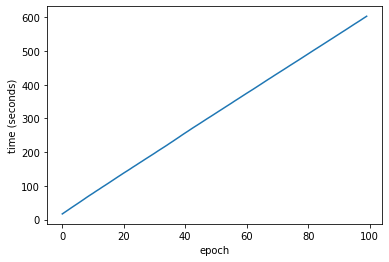

/tmp/ipykernel_15580/85391320.py:13: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "bbox_inces" which is no longer supported as of 3.3 and will become an error in 3.6
  plt.savefig(save_path + 'Figures/time.png',bbox_inces='tight',dpi=100)


<Figure size 432x288 with 0 Axes>

In [20]:
#actually do the training
timetaken = timecallback()
model.fit_generator(generator=gen_train,
                    steps_per_epoch=steps_per_epoch_tr,#the generator internally goes over the entire dataset in one iteration
                    validation_data=(X_val,Y_val),
                    epochs=100,
                    verbose=2,
                    initial_epoch=0,
                    callbacks=[checkpoint, csvlog, timetaken])

In [21]:
np.savetxt(save_path + '/Time/time.csv', timetaken.times, delimiter=",")
timetaken.times

[(0, 16.588403790999998),
 (1, 22.742334915999997),
 (2, 28.946210631999996),
 (3, 35.217063497),
 (4, 41.314943318999994),
 (5, 47.36134450899999),
 (6, 53.514546425999995),
 (7, 59.750755467999994),
 (8, 66.095566347),
 (9, 72.158011899),
 (10, 77.998486138),
 (11, 84.159791512),
 (12, 89.930992476),
 (13, 96.09920265599999),
 (14, 101.89500494),
 (15, 107.832406391),
 (16, 113.899315019),
 (17, 119.953134388),
 (18, 126.04095587699999),
 (19, 131.958744559),
 (20, 137.971243544),
 (21, 143.693997312),
 (22, 149.491303473),
 (23, 155.606147401),
 (24, 161.335840604),
 (25, 167.34175606099998),
 (26, 173.135425712),
 (27, 179.112710732),
 (28, 184.933467508),
 (29, 190.729550469),
 (30, 196.5796178),
 (31, 202.711544927),
 (32, 208.55557427899998),
 (33, 214.350917759),
 (34, 220.23592485),
 (35, 226.41109095599998),
 (36, 232.36095661699997),
 (37, 238.54588888499998),
 (38, 244.64813566299998),
 (39, 250.94093659199999),
 (40, 256.96785113500005),
 (41, 262.90229199500004),
 (42, 26

In [22]:
model.load_weights(save_path + 'Trained_models/'+filepath+'.hdf5')
data_load_start = time.process_time()
Y_ts_hat = model.predict(X_ts,batch_size=1)

#%% iterate over a large number of T models
T = 20 #20 used in DeVries et al 2018
for t in range(T-1):#already did one above
    print('model',t+1,'of',T-1)
    Y_ts_hat=Y_ts_hat+model.predict(X_ts,batch_size=1)
data_load_time = time.process_time()-data_load_start
print(data_load_time)
Y_ts_hat=Y_ts_hat/T
np.save(save_path + 'Data/Y_ts_hat_'+filepath+'.npy',Y_ts_hat)

model 1 of 19
model 2 of 19
model 3 of 19
model 4 of 19
model 5 of 19
model 6 of 19
model 7 of 19


2023-01-17 11:39:01.267662: W tensorflow/core/common_runtime/bfc_allocator.cc:462] Allocator (GPU_0_bfc) ran out of memory trying to allocate 434.00MiB (rounded to 455081984)requested by op ConcatV2
If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
Current allocation summary follows.
Current allocation summary follows.
2023-01-17 11:39:01.267721: I tensorflow/core/common_runtime/bfc_allocator.cc:1010] BFCAllocator dump for GPU_0_bfc
2023-01-17 11:39:01.267737: I tensorflow/core/common_runtime/bfc_allocator.cc:1017] Bin (256): 	Total Chunks: 263, Chunks in use: 263. 65.8KiB allocated for chunks. 65.8KiB in use in bin. 22.4KiB client-requested in use in bin.
2023-01-17 11:39:01.267745: I tensorflow/core/common_runtime/bfc_allocator.cc:1017] Bin (512): 	Total Chunks: 37, Chunks in use: 36. 20.0KiB allocated for chunks. 19.2KiB in use in bin. 17.0KiB client-requested in use in bin.
2023-01-17 11:39:01.26775

ResourceExhaustedError: OOM when allocating tensor with shape[434,512,512,1] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc [Op:ConcatV2] name: concat

In [ ]:
# aleatoric loss function
def aleatoric_loss(y_true, y_pred):
    N = y_true.shape[0]
    se = np.power((y_true[:,0]-y_pred[:,0]),2)
    inv_std = np.exp(-y_pred[:,1])
    mse = np.mean(inv_std*se)
    reg = np.mean(y_pred[:,1])
    return 0.5*(mse + reg)

def dice2D(a,b):
    #https://stackoverflow.com/questions/31273652/how-to-calculate-dice-coefficient-for-measuring-accuracy-of-image-segmentation-i
    #https://en.wikipedia.org/wiki/S%C3%B8rensen%E2%80%93Dice_coefficient
    intersection = np.sum(a[b==1])
    dice = (2*intersection)/(np.sum(a)+np.sum(b))
    if (np.sum(a)+np.sum(b))==0: #black/empty masks
        dice=1.0
    return(dice)


In [ ]:
#%%calculate uncertainty
Ntest=len(X_ts)
Y_ts_hat=np.load(save_path + 'Data/Y_ts_hat_'+filepath+'.npy')
P_foreground = Y_ts_hat + 1e-10
P_background = 1-P_foreground + 1e-10

U_ts = -(P_foreground*np.log(P_foreground)+P_background*np.log(P_background))
#np.save('./data/U_ts_'+filepath+'.npy',U_ts)

U_ts_foreground=-(P_foreground*np.log(P_foreground))
U_ts_background=-(P_background*np.log(P_background))
#%% convert predicted mask to binary

a_uncertainty = []
for i in range(Ntest):
    #print(i)
    a_uncertainty.append(aleatoric_loss(Y_ts[i,:,:,0],Y_ts_hat[i,:,:,0]))
a_uncertainty = np.array(a_uncertainty)

threshold=0.5
Y_ts_hat[Y_ts_hat<threshold]=0
Y_ts_hat[Y_ts_hat>=threshold]=1
plt.imshow(Y_ts_hat[0,:,:,0]);plt.colorbar()

#%% calculate dice
dice = []
for i in range(Ntest):
    #print(i)
    dice.append(dice2D(Y_ts[i,:,:,0],Y_ts_hat[i,:,:,0]))
dice = np.array(dice)

In [ ]:
#%%
Ntest = 10
fig, axes = plt.subplots(Ntest,6,figsize=(4*5,Ntest*5))
for i in range(Ntest):
    axes[i,0].imshow(X_ts[i,:,:,0])
    axes[i,0].set_xticks([])
    axes[i,0].set_yticks([])
    axes[i,0].set_title('input 1: c1',{'fontsize':16})
    axes[i,0].set_ylabel(wells[i],{'fontsize':16})
    
    axes[i,1].imshow(X_ts[i,:,:,1])
    axes[i,1].set_xticks([])
    axes[i,1].set_yticks([])
    axes[i,1].set_title('input 2: c2',{'fontsize':16})
    
    axes[i,2].imshow(X_ts[i,:,:,2])
    axes[i,2].set_xticks([])
    axes[i,2].set_yticks([])
    axes[i,2].set_title('input 2: c3',{'fontsize':16})
    
    axes[i,3].imshow(Y_ts[i,:,:,0], cmap='gray')
    axes[i,3].set_xticks([])
    axes[i,3].set_yticks([])
    axes[i,3].set_title('True',{'fontsize':16})
#    
    axes[i,4].imshow(Y_ts_hat[i,:,:,0], cmap='gray')
    axes[i,4].set_xticks([])
    axes[i,4].set_yticks([])
    axes[i,4].set_title('Predicted, dice='+str(np.round(dice[i],2)),{'fontsize':16})
    
    axes[i,5].imshow(U_ts[i,:,:,0], cmap='gray')
    axes[i,5].set_xticks([])
    axes[i,5].set_yticks([])
    axes[i,5].set_title('Uncertainty',{'fontsize':16})
plt.savefig(save_path + 'Figures/test_set_all_'+filepath+'.png',bbox_inches='tight',dpi=100)

In [ ]:
#%%
fig, axes = plt.subplots(Ntest,3,figsize=(3*4,Ntest*4))
for i in range(Ntest):

    axes[i,0].imshow(Y_ts[i,:,:,0], cmap='gray')
    axes[i,0].set_xticks([])
    axes[i,0].set_yticks([])
    axes[i,0].set_title('True',{'fontsize':16})
    axes[i,0].set_ylabel(wells[i],{'fontsize':16})
    
    axes[i,1].imshow(Y_ts_hat[i,:,:,0], cmap='gray')
    axes[i,1].set_xticks([])
    axes[i,1].set_yticks([])
    axes[i,1].set_title('Predicted, dice='+str(np.round(dice[i],2)),{'fontsize':16})
    
    axes[i,2].imshow(U_ts[i,:,:,0], cmap='gray')
    axes[i,2].set_xticks([])
    axes[i,2].set_yticks([])
    axes[i,2].set_title('Uncertainty',{'fontsize':16})
    
plt.savefig(save_path + 'Figures/test_set_predictions_'+filepath+'.png',bbox_inches='tight',dpi=100)

print('mean dice:', dice.mean())
#0.9025007125385125
print('median dice:', np.median(dice))
#0.9051728188144481
np.save(save_path + 'Data/dice_'+filepath+'.npy',dice)

In [ ]:
dice

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(6,6))
ax.boxplot(dice, labels = ['MCD UNET'])
ax.set_ylabel('Dice Score',{'fontsize':16})
ax.text(1.1,np.median(dice),str(np.round(np.median(dice),3)),size=16)
plt.savefig(save_path + 'Figures/dicescore.png',bbox_inces='tight',dpi=100)

In [ ]:
np.median(dice)